# Multi-user IoU

For the machine learning algorithm to work it is crucial to establish a satistfactory ground-truth. We probably don't have to deal with spammers in our dataset but still with persons who were interpreting our classes differently. So the question this notebook likes to answer is:

**How to connect user scores with each other?**

In order to establish these connections, one could set all bilateral user scores (e.g. IoU) into relationship. In the following, the IoUs are calculated on the full dataset for every combination of users that have classified a specific image with a specific class. The averaged user-user IoUs are shown in a matrix and are sorted by there standard deviation. A user with a low standard deviation, meaning that all his IoUs with other users are similar ( not necessarily high!). Based on such a matrix, one could try to find the centroid of these IoUs.
For three users I would think this could work as follows: each user pair (permutations and identities ignored) gets one dimension.
user1-user2: IoU as radius
user1-user3: IoU as azimuth
user2-user3: IoU as elevation
From those three points in a sphere the centroid can be easily found. Defining a sphere around this centroid with radius r could be used as a threshold. Points within that sphere are regareded as 'good classifiers' and outside as 'bad classifiers'.
With four users and more this gets much more complicated as the number of pairs is higher than the number of users, however this would be my current idea.

In [307]:
from pyclouds import iou
from pyclouds.imports import *
from tqdm import tqdm_notebook as tqdm
from itertools import product
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from pyclouds.zooniverse import *
from pyclouds.helpers import *

In [103]:
clas_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_16.csv'
subj_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'
img_size = (2100, 1400)

In [104]:
classes = ['Sugar', 'Flower', 'Fish', 'Gravel']

In [105]:
subj = load_classifications(subj_in)

In [106]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}

In [107]:
subj2fn = {}
for i, r in subj.iterrows():
    if r['subject_set_id'] in list(subjects_name.keys()):
        subj2fn[r['subject_id']] =  r['metadata']['fn']

In [108]:
clas = parse_classifications(clas_in,json_columns=['metadata', 'annotations', 'subject_data'])

In [109]:
clas['datetime'] = pd.to_datetime(clas['created_at'])

In [378]:
clas_full = clas[(clas['workflow_name'] == 'Full dataset')]

In [379]:
clas_full.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,datetime
13,128932300,raspstephan,1814911.0,ece34b7062ff27190425,8073,Full dataset,13.11,2018-10-28 10:00:31 UTC,NaN,NaN,"{'source': 'api', 'session': '72e7236d3736b33e...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976410': {'retired': None, 'fn': '/project...",26976410,2018-10-28 10:00:31
23,129485502,not-logged-in-80bdc4acf6d39d1ea32e,NaN,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:15:14 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27144341': {'retired': {'id': 24673754, 'wor...",27144341,2018-11-01 08:15:14
24,129485553,not-logged-in-80bdc4acf6d39d1ea32e,NaN,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:16:38 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27146358': {'retired': {'id': 24675851, 'wor...",27146358,2018-11-01 08:16:38
25,129485578,not-logged-in-80bdc4acf6d39d1ea32e,NaN,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:16:53 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27161730': {'retired': {'id': 24706423, 'wor...",27161730,2018-11-01 08:16:53
26,129485596,not-logged-in-80bdc4acf6d39d1ea32e,NaN,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:17:11 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27139667': {'retired': {'id': 24666988, 'wor...",27139667,2018-11-01 08:17:11


In [380]:
annos_full = annos_from_df(clas_full, img_size)

In [381]:
subjects_full = list(annos_full.keys()); len(subjects_full)

9751

In [382]:
# Initialize IoU dict for every possible pairing of users
IoU_pairs = {}
for pair in product(np.unique(clas_full.user_name),repeat=2):
    IoU_pairs[pair[0]+'->'+pair[1]] = [0, 0]

In [383]:
annos_df = pd.DataFrame(data=None,columns=['subject_id','user','x','y','w','h','label'])

ind = 0
for key,values in annos_full.items():
    for value in values:
        annos_df.loc[ind,:] = [key,value[0],value[1][0],value[1][1],value[1][2],value[1][3],value[2]]
        ind+=1

In [384]:
verbose=False
# Loop over images
for subject_id, subj_df in tqdm(annos_df.groupby('subject_id')):
    # Disregard images that have been classified by one person only
    if len(np.unique(subj_df.user)) <= 1:
        continue
    # Loop over classes indentified within image
    classes_identified = np.unique(subj_df.label[subj_df.label.values != None])
    # Exclude 'None' classifications
    classes_identified_uniq = np.unique(classes_identified[classes_identified != None])
    for class_, class_df in subj_df.groupby('label'):
        # Combine user labels of one class to a filled array
        user_boxes = {}
        for user, user_df in class_df.groupby('user'):
            arr1 = iou.fill_array_with_boxes(user_df.iloc[:,2:6].values, (1500,1500))
            user_boxes[user] = arr1
        # Calculate IoU among the users having classified this image and with this class
        # NOTE: Currently the whole union and intersection is used, even if there was partly no overlap
        for user_combinations in product(user_boxes.keys(),repeat=2):
            user1, user2 = user_combinations
            if verbose:
                plt.imshow(user_boxes[user1]*2+user_boxes[user2]*1,cmap='Blues')
                plt.title('subject:{}, intersection of {} with {} for class {}'.format(subject_id, user1,user2,class_))
                plt.show()
                plt.close()
            union = np.count_nonzero(np.logical_or(user_boxes[user1],user_boxes[user2]))
            intersection = np.count_nonzero(np.logical_and(user_boxes[user1],user_boxes[user2]))
            try:
                IoU_pairs[user1+'->'+user2] = [IoU_pairs[user1+'->'+user2][0]+intersection/union, IoU_pairs[user1+'->'+user2][1]+1]
            except ZeroDivisionError:
                continue

In [323]:
IoU_pairs

{'Armin.haghshenas->Armin.haghshenas': [517.0, 517],
 'Armin.haghshenas->CKauhs': [3.422095135469926, 10],
 'Armin.haghshenas->CStephan': [2.0308942760936954, 9],
 'Armin.haghshenas->DelaS': [4.080336902430677, 11],
 'Armin.haghshenas->JuleR': [3.9663409134733367, 8],
 'Armin.haghshenas->Julia.Windmiller': [6.226449652857044, 15],
 'Armin.haghshenas->LWMPI': [2.382417334102316, 12],
 'Armin.haghshenas->MarcusKlingebiel': [4.575302315757874, 10],
 'Armin.haghshenas->ReinhardB': [2.414140197165296, 6],
 'Armin.haghshenas->Saybot': [3.05237860165139, 9],
 'Armin.haghshenas->Serikov': [10.3738683062021, 20],
 'Armin.haghshenas->ShCu': [4.436932431482912, 12],
 'Armin.haghshenas->TobiasBecker': [7.986553528598509, 16],
 'Armin.haghshenas->Uthlande': [4.289603265501083, 12],
 'Armin.haghshenas->Wolkengebilde': [0.24346590627346928, 3],
 'Armin.haghshenas->akio': [1.9511293133469705, 7],
 'Armin.haghshenas->anna.luebke': [2.709883746256872, 5],
 'Armin.haghshenas->biancorosa': [5.574283664275

In [385]:
# Create IoU matrix
user_index_dict = {}
for ind, name in enumerate(np.unique(annos_df.user)):
    user_index_dict[name] = ind

In [386]:
IoU_matrix = np.zeros((len(np.unique(annos_df.user)),len(np.unique(annos_df.user))))
for pair, values in IoU_pairs.items():
    IoU_sum, N = values
    if N > 0:
        IoU_mean = IoU_sum/N
    else:
        IoU_mean = np.nan
    user1_name, user2_name = pair.split('->')
    user1_id = user_index_dict[user1_name]
    user2_id = user_index_dict[user2_name]
    IoU_matrix[user1_id, user2_id] = IoU_mean

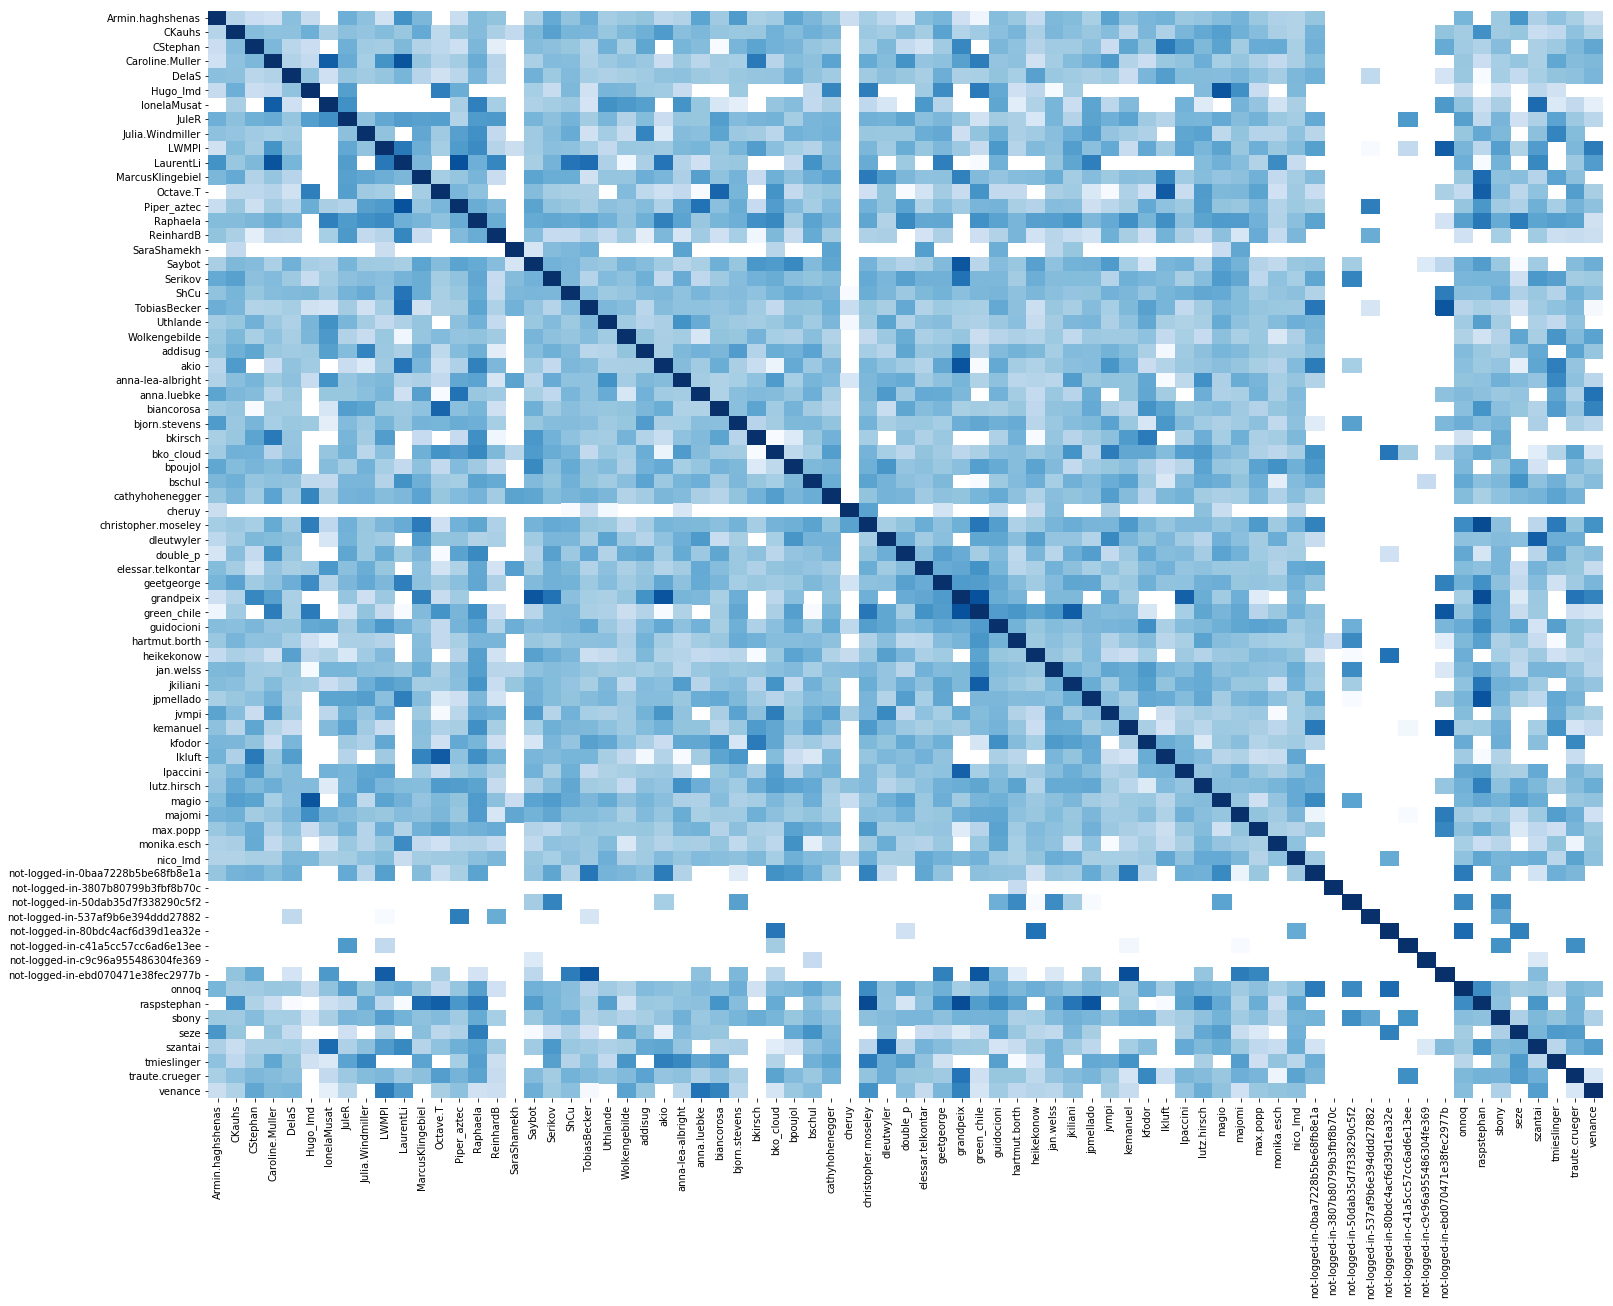

In [404]:
import seaborn as sns
plt.figure(figsize=(25,20))
ax = sns.heatmap(IoU_matrix, annot=False, cmap='Blues',cbar=False)
ax.set_xticklabels(user_index_dict.keys(),rotation=90);
ax.set_yticklabels(user_index_dict.keys(),rotation=0);

I forgot to split the results by classes during the calculation, so this is now the mean for all classes.

Sorting the matrix by the standard deviation each user has among its IoU should give a rough estimate, how its total ranking among the users is. Although actually the mean should by high as well! However, the matrix calculated based on the mean (just change the next line) does not show a clear behaviour.

In [416]:
sort_ind = np.argsort(np.nanstd(IoU_matrix,axis=1))

In [417]:
users = np.array(list(user_index_dict.keys()))

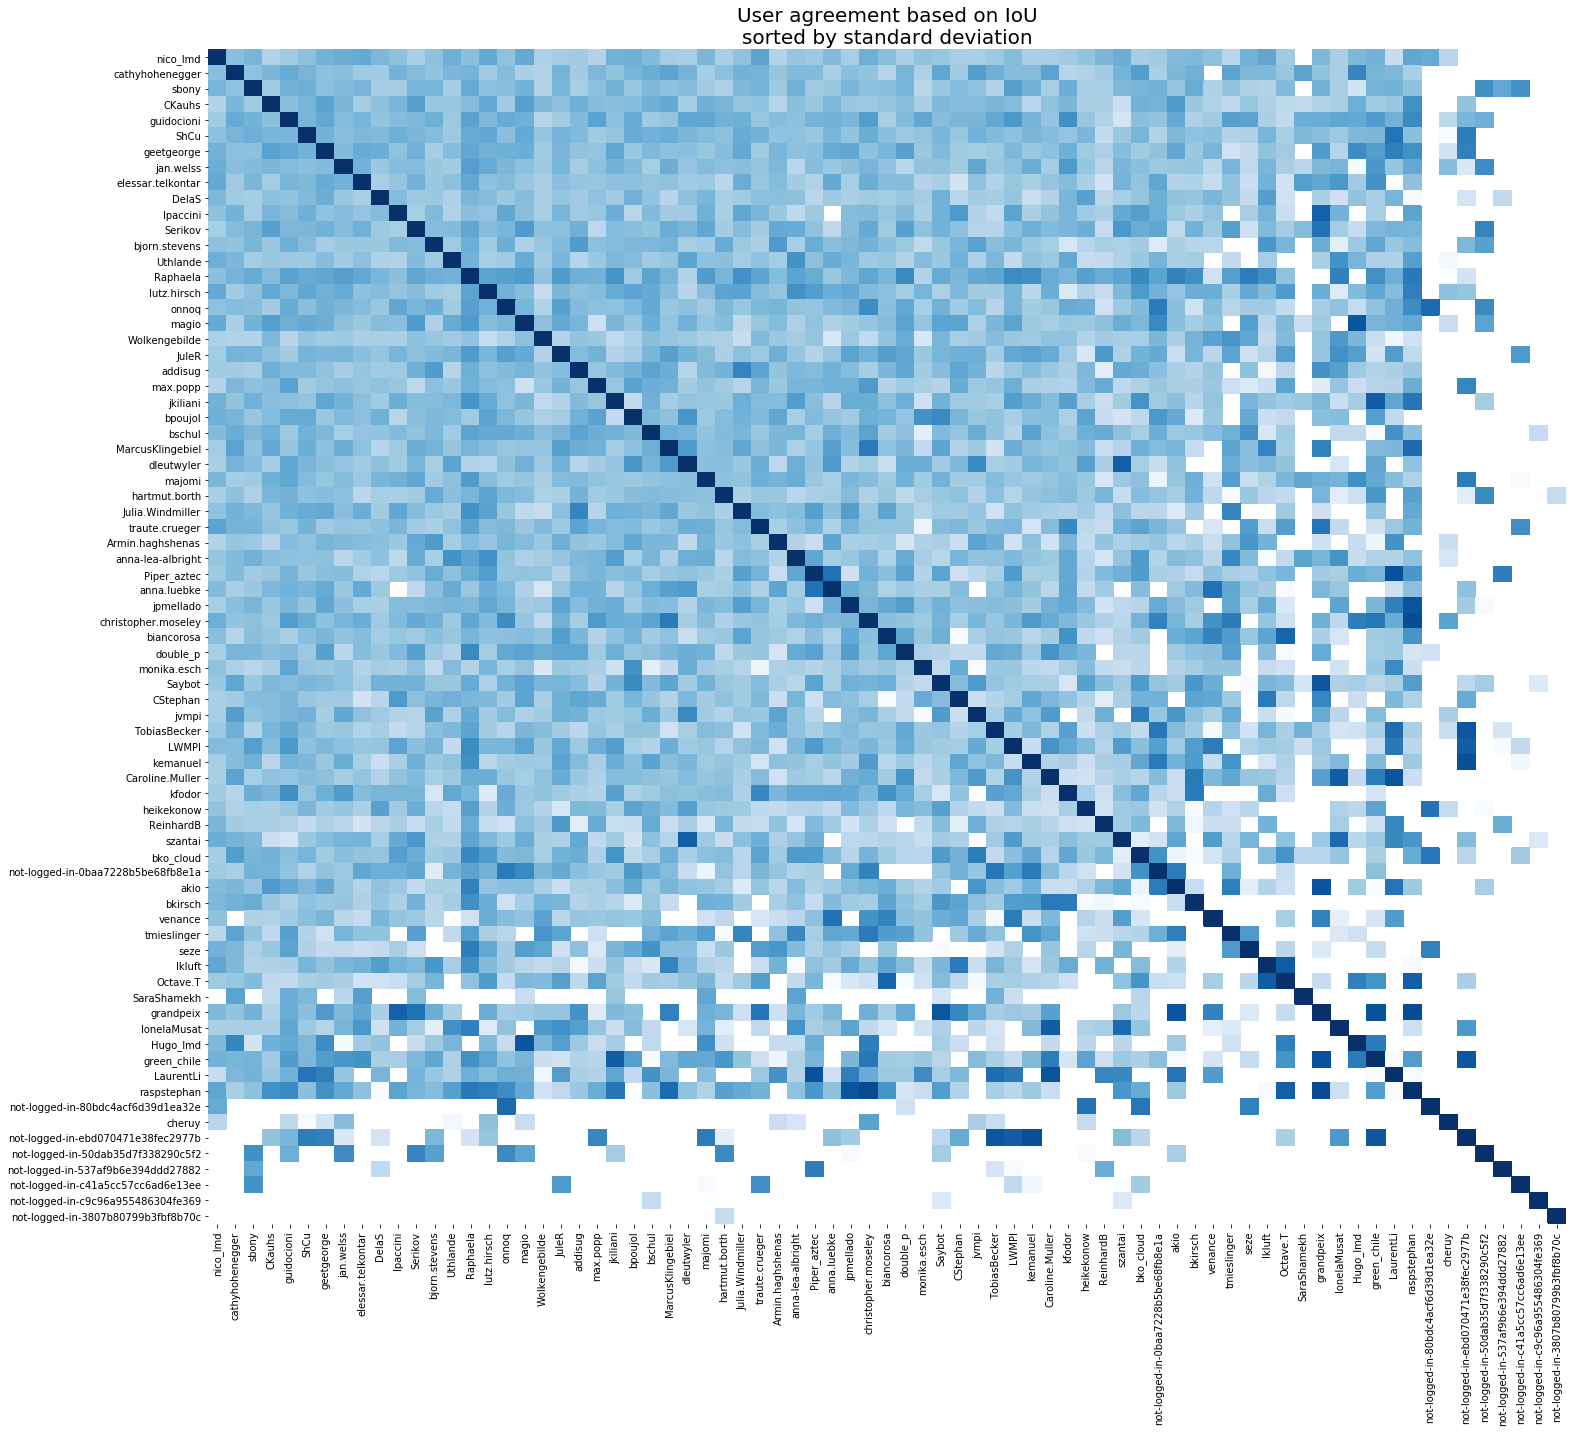

In [418]:
plt.figure(figsize=(22,20))
plt.title('User agreement based on IoU\nsorted by standard deviation',fontsize=20)
ax = sns.heatmap(IoU_matrix[sort_ind][:,sort_ind], annot=False, cmap='Blues',cbar=False)
ax.set_xticklabels(users[sort_ind],rotation=90);
ax.set_yticklabels(users[sort_ind],rotation=0);
plt.tight_layout()

## Retrieve cluster of user

Now a further difficulty is to decide on a threshold, which users we would trust and which we will not. I first thought of creating an N dimensional space where N is equal to the number of user pairs (without permutations and identities) and each IoU would be the support of a point in space. Then one could find the centroid and define some sort of n-sphere around this. Points/Users within this sphere would be trusted, the others not.
So basically a k-mean analysis with k=1.

## Validating the selection

After we found a group of users we can trust, I would validate our approach by comparing e.g. the mean IoU of the practical dataset with all users to the mean IoU from the 'good' users only. If this leads to an improvement, we have done a good job!

## Still to do
- think about a good IoU or comparable measure
- decide on 'good' and 'bad' users
- include the type of class in the decision making (i.e. one user agrees well with others for fish, but has low IoUs when he classifies sugar)

Hauke out!